<a href="https://colab.research.google.com/github/vektor8891/llm/blob/main/projects/06_word2vec/06_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torchtext==0.15.1
# !pip install numpy
# !pip install gensim
# !pip install portalocker

In [2]:
import numpy

import matplotlib.pyplot as plt
from torchtext.vocab import GloVe, vocab, build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
# Define a function to plot word embeddings in a 2d space.
def plot_embeddings(word_embeddings,vocab=vocab):

    tsne = TSNE(n_components=2, random_state=0)
    word_embeddings_2d = tsne.fit_transform(word_embeddings)

    # Plotting the results with labels from vocab
    plt.figure(figsize=(15, 15))
    for i, word in enumerate(vocab.get_itos() ):  # assuming vocab.itos gives the list of words in your vocab
        plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
        plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]))

    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.title("Word Embeddings visualized with t-SNE")
    plt.show()

In [4]:
# This function returns the most similar words to a target word by calculating word vectors' cosine distance
def find_similar_words(word, word_embeddings, top_k=5):
    if word not in word_embeddings:
        print("Word not found in embeddings.")
        return []

    # Get the embedding for the given word
    target_embedding = word_embeddings[word]

    # Calculate cosine similarities between the target word and all other words
    similarities = {}
    for w, embedding in word_embeddings.items():
        if w != word:
            similarity = torch.dot(target_embedding, embedding) / (
                torch.norm(target_embedding) * torch.norm(embedding)
            )
            similarities[w] = similarity.item()

    # Sort the similarities in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Return the top k similar words
    most_similar_words = [w for w, _ in sorted_similarities[:top_k]]
    return most_similar_words

In [5]:
# Define a function that trains word2vec model on toy data
def train_model(model, dataloader, criterion, optimizer, num_epochs=1000):
    """
    Train the model for the specified number of epochs.

    Args:
        model: The PyTorch model to be trained.
        dataloader: DataLoader providing data for training.
        criterion: Loss function.
        optimizer: Optimizer for updating model's weights.
        num_epochs: Number of epochs to train the model for.

    Returns:
        model: The trained model.
        epoch_losses: List of average losses for each epoch.
    """

    # List to store running loss for each epoch
    epoch_losses = []

    for epoch in tqdm(range(num_epochs)):
        # Storing running loss values for the current epoch
        running_loss = 0.0

        # Using tqdm for a progress bar
        for idx, samples in enumerate(dataloader):

            optimizer.zero_grad()

            # Check for EmbeddingBag layer in the model
            if any(isinstance(module, nn.EmbeddingBag) for _, module in model.named_modules()):
                target, context, offsets = samples
                predicted = model(context, offsets)

            # Check for Embedding layer in the model
            elif any(isinstance(module, nn.Embedding) for _, module in model.named_modules()):
                target, context = samples
                predicted = model(context)

            loss = criterion(predicted, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            running_loss += loss.item()

        # Append average loss for the epoch
        epoch_losses.append(running_loss / len(dataloader))

    return model, epoch_losses

# Create and train word2vec models

In [6]:
toy_data = """I wish I was little bit taller
I wish I was a baller
She wore a small black dress to the party
The dog chased a big red ball in the park
He had a huge smile on his face when he won the race
The tiny kitten played with a fluffy toy mouse
The team celebrated their victory with a grand parade
She bought a small, delicate necklace for her sister
The mountain peak stood majestic and tall against the clear blue sky
The toddler took small, careful steps as she learned to walk
The house had a spacious backyard with a big swimming pool
He felt a sense of accomplishment after completing the challenging puzzle
The chef prepared a delicious, flavorful dish using fresh ingredients
The children played happily in the small, cozy room
The book had an enormous impact on readers around the world
The wind blew gently, rustling the leaves of the tall trees
She painted a beautiful, intricate design on the small canvas
The concert hall was filled with thousands of excited fans
The garden was adorned with colorful flowers of all sizes
I hope to achieve great success in my chosen career path
The skyscraper towered above the city, casting a long shadow
He gazed in awe at the breathtaking view from the mountaintop
The artist created a stunning masterpiece with bold brushstrokes
The baby took her first steps, a small milestone that brought joy to her parents
The team put in a tremendous amount of effort to win the championship
The sun set behind the horizon, painting the sky in vibrant colors
The professor gave a fascinating lecture on the history of ancient civilizations
The house was filled with laughter and the sound of children playing
She received a warm, enthusiastic welcome from the audience
The marathon runner had incredible endurance and determination
The child's eyes sparkled with excitement upon opening the gift
The ship sailed across the vast ocean, guided by the stars
The company achieved remarkable growth in a short period of time
The team worked together harmoniously to complete the project
The puppy wagged its tail, expressing its happiness and affection
She wore a stunning gown that made her feel like a princess
The building had a grand entrance with towering columns
The concert was a roaring success, with the crowd cheering and clapping
The baby took a tiny bite of the sweet, juicy fruit
The athlete broke a new record, achieving a significant milestone in her career
The sculpture was a masterpiece of intricate details and craftsmanship
The forest was filled with towering trees, creating a sense of serenity
The children built a small sandcastle on the beach, their imaginations running wild
The mountain range stretched as far as the eye could see, majestic and awe-inspiring
The artist's brush glided smoothly across the canvas, creating a beautiful painting
She received a small token of appreciation for her hard work and dedication
The orchestra played a magnificent symphony that moved the audience to tears
The flower bloomed in vibrant colors, attracting butterflies and bees
The team celebrated their victory with a big, extravagant party
The child's laughter echoed through the small room, filling it with joy
The sunflower stood tall, reaching for the sky with its bright yellow petals
The city skyline was dominated by tall buildings and skyscrapers
The cake was adorned with a beautiful, elaborate design for the special occasion
The storm brought heavy rain and strong winds, causing widespread damage
The small boat sailed peacefully on the calm, glassy lake
The artist used bold strokes of color to create a striking and vivid painting
The couple shared a passionate kiss under the starry night sky
The mountain climber reached the summit after a long and arduous journey
The child's eyes widened in amazement as the magician performed his tricks
The garden was filled with the sweet fragrance of blooming flowers
The basketball player made a big jump and scored a spectacular slam dunk
The cat pounced on a small mouse, displaying its hunting instincts
The mansion had a grand entrance with a sweeping staircase and chandeliers
The raindrops fell gently, creating a rhythmic patter on the roof
The baby took a big step forward, encouraged by her parents' applause
The actor delivered a powerful and emotional performance on stage
The butterfly fluttered its delicate wings, mesmerizing those who watched
The company launched a small-scale advertising campaign to test the market
The building was constructed with strong, sturdy materials to withstand earthquakes
The singer's voice was powerful and resonated throughout the concert hall
The child built a massive sandcastle with towers, moats, and bridges
The garden was teeming with a variety of small insects and buzzing bees
The athlete's muscles were well-developed and strong from years of training
The sun cast long shadows as it set behind the mountains
The couple exchanged heartfelt vows in a beautiful, intimate ceremony
The dog wagged its tail vigorously, a sign of excitement and happiness
The baby let out a tiny giggle, bringing joy to everyone around"""

In [7]:
# Prepare data by tokenizing it and creating a vocabulary from data

# Step 1: Get tokenizer
tokenizer = get_tokenizer('basic_english')  # This uses basic English tokenizer. You can choose another.

# Step 2: Tokenize sentences
def tokenize_data(sentences):
    for sentence in sentences:
        yield tokenizer(sentence)

tokenized_toy_data = tokenizer(toy_data)

vocab = build_vocab_from_iterator(tokenize_data(tokenized_toy_data), specials=['<unk>'])
vocab.set_default_index(vocab["<unk>"])


In [8]:
# Check sentence after tokenization and numericalization

# Test
sample_sentence = "I wish I was a baller"
tokenized_sample = tokenizer(sample_sentence)
encoded_sample = [vocab[token] for token in tokenized_sample]
print("Encoded sample:", encoded_sample)

Encoded sample: [20, 108, 20, 7, 2, 133]


In [9]:
# Create fuction to apply numericalization on all tokens

text_pipeline = lambda tokens:[ vocab[token]  for token in tokens]

## Continuous Bag of Words (CBOW)

In [10]:
# context: set of surrounding words (e.g. context window of size 2 means you take two words before and two words after the target word as context)

CONTEXT_SIZE = 2

cobow_data = []

for i in range(CONTEXT_SIZE, len(tokenized_toy_data ) - CONTEXT_SIZE):

    context = (
        [tokenized_toy_data[i - CONTEXT_SIZE + j] for j in range(CONTEXT_SIZE)]
        + [tokenized_toy_data[i + j + 1] for j in range(CONTEXT_SIZE)]
    )

    target = tokenized_toy_data[i]
    cobow_data.append((context, target))

print(cobow_data[0])
print(cobow_data[1])

(['i', 'wish', 'was', 'little'], 'i')
(['wish', 'i', 'little', 'bit'], 'was')


In [11]:
# collate_batch function: processes batches of data, converting context and target text data into numerical format using a vocabulary and arranging them for model training

def collate_batch(batch):
    target_list, context_list, offsets = [], [], [0]
    for _context, _target in batch:

        target_list.append(vocab[_target])
        processed_context = torch.tensor(text_pipeline(_context), dtype=torch.int64)
        context_list.append(processed_context)
        offsets.append(processed_context.size(0))
    target_list = torch.tensor(target_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    context_list = torch.cat(context_list)
    return target_list.to(device), context_list.to(device), offsets.to(device)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
# Process first 10 samples from the `cobow_data` using `collate_batch`. The outputs are:
# - `target_list`: tokenized target words
# - `context_list`: surrounding context words
# - `offsets`: respective offsets for each sample
target_list, context_list, offsets=collate_batch(cobow_data[0:10])
print(f"target_list (Tokenized target words):\n\t{target_list})")
print(f"context_list (Surrounding context words):\n\t{context_list}")
print(f"offsets (Starting indexes of context words for each target):\n\t{offsets}")

target_list (Tokenized target words):
	tensor([ 20,   7, 272, 136, 376,  20, 108,  20,   7,   2]))
context_list (Surrounding context words):
	tensor([ 20, 108,   7, 272, 108,  20, 272, 136,  20,   7, 136, 376,   7, 272,
        376,  20, 272, 136,  20, 108, 136, 376, 108,  20, 376,  20,  20,   7,
         20, 108,   7,   2, 108,  20,   2, 133,  20,   7, 133,  14])
offsets (Starting indexes of context words for each target):
	tensor([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36])


In [14]:
# Create dataLoader object
BATCH_SIZE = 64  # batch size for training

dataloader_cbow = DataLoader(
    cobow_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
print(dataloader_cbow)

In [15]:
class CBOW(nn.Module):
    # Initialize the CBOW model
    def __init__(self, vocab_size, embed_dim, num_class):

        super(CBOW, self).__init__()
         # Define the embedding layer using nn.EmbeddingBag
        # It outputs the average of context words embeddings
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        # Define the first linear layer with input size embed_dim and output size embed_dim//2
        self.linear1 = nn.Linear(embed_dim, embed_dim//2)
        # Define the fully connected layer with input size embed_dim//2 and output size vocab_size
        self.fc = nn.Linear(embed_dim//2, vocab_size)


        self.init_weights()
    # Initialize the weights of the model's parameters
    def init_weights(self):
        # Initialize the weights of the embedding layer
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # Initialize the weights of the fully connected layer
        self.fc.weight.data.uniform_(-initrange, initrange)
        # Initialize the biases of the fully connected layer to zeros
        self.fc.bias.data.zero_()


    def forward(self, text, offsets):
        # Pass the input text and offsets through the embedding layer
        out = self.embedding(text, offsets)
        # Apply the ReLU activation function to the output of the first linear layer
        out = torch.relu(self.linear1(out))
        # Pass the output of the ReLU activation through the fully connected layer
        return self.fc(out)


In [16]:
# Create an instance of the CBOW model
vocab_size = len(vocab)
emsize = 24
model_cbow = CBOW(vocab_size, emsize, vocab_size).to(device)

In [17]:
# Define the loss function, optimizer, and scheduler for training
LR = 5  # learning rate

# Define the CrossEntropyLoss criterion. It is commonly used for multi-class classification tasks.
# This criterion combines the softmax function and the negative log-likelihood loss.
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer using stochastic gradient descent (SGD).
# It optimizes the parameters of the model_cbow, which are obtained by model_cbow.parameters().
# The learning rate (lr) determines the step size for parameter updates during optimization.
optimizer = torch.optim.SGD(model_cbow.parameters(), lr=LR)

# Define a learning rate scheduler.
# The StepLR scheduler adjusts the learning rate during training.
# It multiplies the learning rate by gamma every step_size epochs (here, 1.0).
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)


In [18]:
# train model
model_cbow, epoch_losses = train_model(model_cbow, dataloader_cbow, criterion, optimizer, num_epochs=400)

100%|██████████| 400/400 [00:19<00:00, 20.12it/s]


Text(0.5, 0, 'epochs')

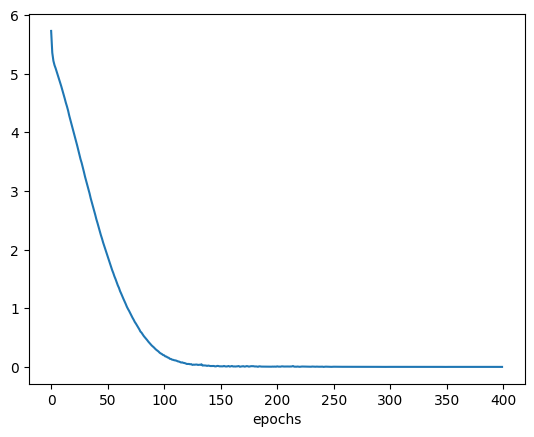

In [19]:
plt.plot(epoch_losses)
plt.xlabel("epochs")

In [20]:
# !pip uninstall numpy
# !pip install "numpy<2"

In [21]:
# Load model weights (actual word embeddings) into numpy array
word_embeddings = model_cbow.embedding.weight.detach().cpu().numpy()
word_embeddings

array([[ 0.04974443,  0.45710915, -0.32480967, ..., -0.13542384,
        -0.19244736,  0.23854572],
       [-1.240186  , -0.31852436,  2.4754355 , ..., -0.88152534,
        -0.8964767 , -0.10772963],
       [-1.3505712 , -1.3658326 , -0.07912935, ...,  0.01689928,
         1.0790465 , -0.35166362],
       ...,
       [ 0.12402517, -0.4486209 , -0.0592917 , ...,  0.3038565 ,
         0.40996903,  0.8395549 ],
       [ 0.15508491, -0.34438103, -0.06903934, ..., -0.8153672 ,
        -0.30510628,  0.42431548],
       [ 0.5042901 ,  0.18051954, -0.15380526, ..., -0.34948063,
        -0.15369935,  0.33909905]], dtype=float32)

In [22]:
# Check embedded vector for a sample word.
# (Notice vector shape equals to the `emsize = 24` defined earlier)
word = 'baller'
word_index = vocab.get_stoi()[word] # getting the index of the word in the vocab
print(word_embeddings[word_index])

[ 0.37385213 -0.39452326 -0.11325395  0.04547798  0.32033834  0.44288948
  0.718141   -0.05053043 -0.33025062  0.36425138  0.3688044   0.722326
 -0.14152768 -0.10546924  0.38766173  0.60905945  0.90957725 -0.23092237
 -0.51058704 -0.41992366 -0.55112344  0.19394426  0.5819516   0.4085451 ]


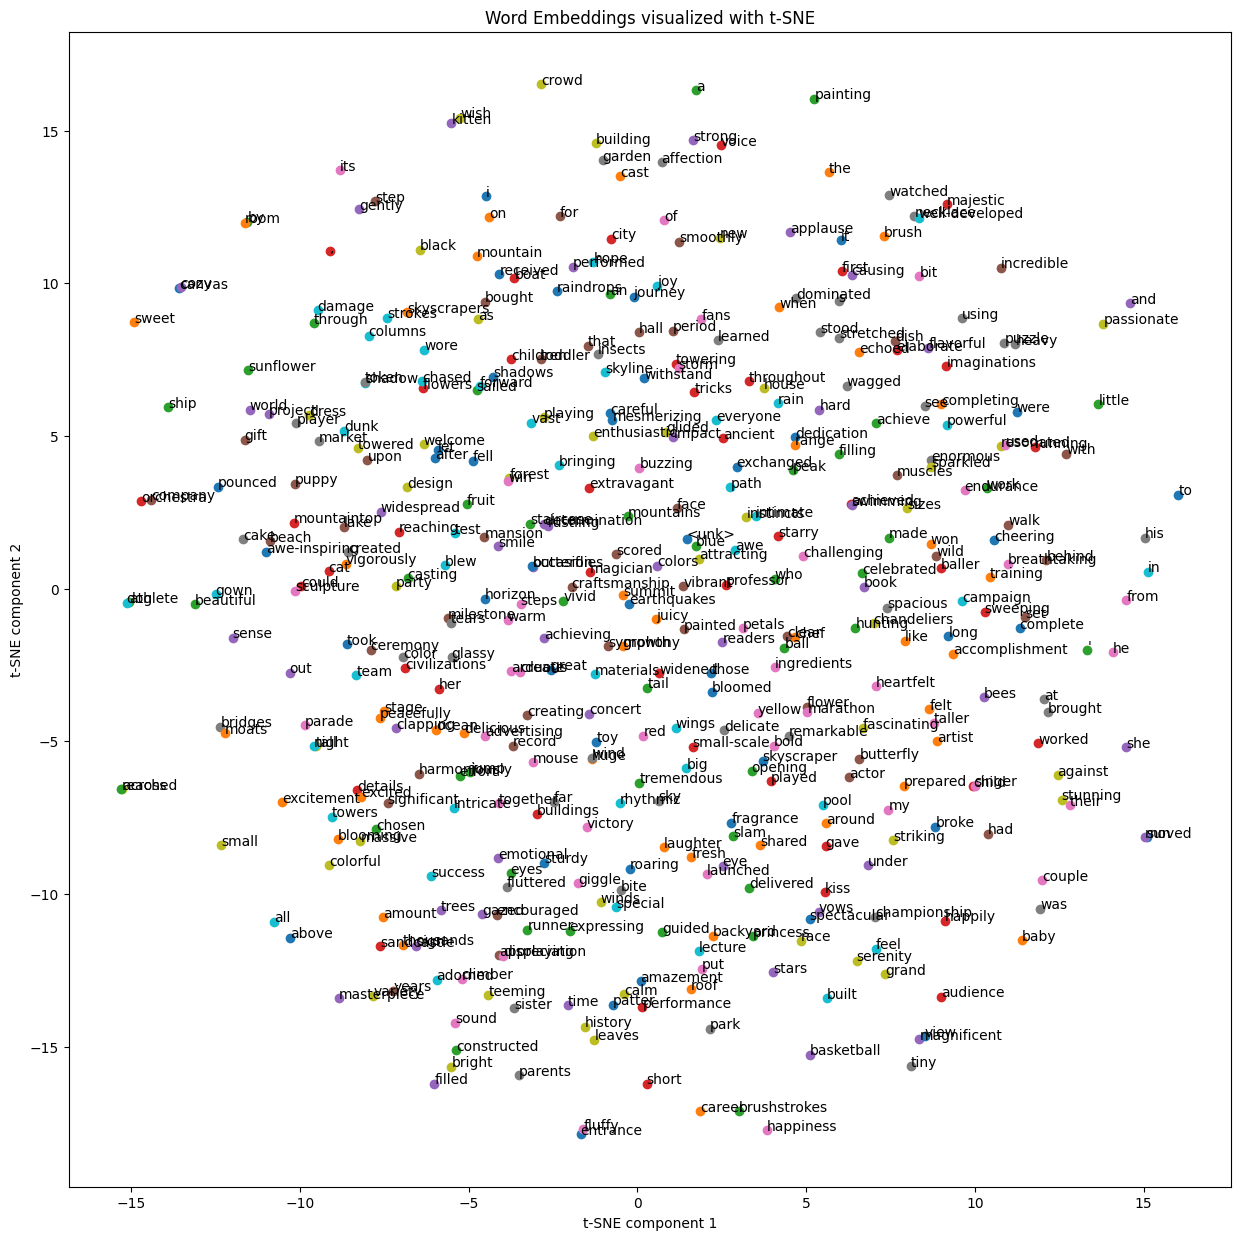

In [23]:
plot_embeddings(word_embeddings,vocab=vocab)

## Skip-gram model

In [24]:
# Define the window size for the context around the target word.
CONTEXT_SIZE = 2

# Initialize an empty list to store the (target, context) pairs.
skip_data = []

# Iterate over each word in the tokenized toy_data, while excluding the first
# and last few words determined by the CONTEXT_SIZE.
for i in range(CONTEXT_SIZE, len(tokenized_toy_data) - CONTEXT_SIZE):

    # For a word at position i, the context comprises of words from the preceding CONTEXT_SIZE
    # as well as from the succeeding CONTEXT_SIZE. The context words are collected in a list.
    context = (
        [tokenized_toy_data[i - j - 1] for j in range(CONTEXT_SIZE)]  # Preceding words
        + [tokenized_toy_data[i + j + 1] for j in range(CONTEXT_SIZE)]  # Succeeding words
    )

    # The word at the current position i is taken as the target.
    target = tokenized_toy_data[i]

    # Append the (target, context) pair to the skip_data list.
    skip_data.append((target, context))

In [25]:
# Window the skipgram
skip_data_=[[(sample[0],word) for word in  sample[1]] for sample in skip_data]
skip_data_flat= [item  for items in  skip_data_ for item in items]
skip_data_flat[8:28]

[('little', 'was'),
 ('little', 'i'),
 ('little', 'bit'),
 ('little', 'taller'),
 ('bit', 'little'),
 ('bit', 'was'),
 ('bit', 'taller'),
 ('bit', 'i'),
 ('taller', 'bit'),
 ('taller', 'little'),
 ('taller', 'i'),
 ('taller', 'wish'),
 ('i', 'taller'),
 ('i', 'bit'),
 ('i', 'wish'),
 ('i', 'i'),
 ('wish', 'i'),
 ('wish', 'taller'),
 ('wish', 'i'),
 ('wish', 'was')]

In [26]:
# Create collate function to numericalize (target, context) pairs
def collate_fn(batch):
    target_list, context_list = [], []
    for _context, _target in batch:

        target_list.append(vocab[_target])
        context_list.append(vocab[_context])

    target_list = torch.tensor(target_list, dtype=torch.int64)
    context_list = torch.tensor(context_list, dtype=torch.int64)
    return target_list.to(device), context_list.to(device)

In [27]:
dataloader = DataLoader(skip_data_flat, batch_size=BATCH_SIZE, collate_fn=collate_fn)
next(iter(dataloader))

(tensor([108,  20,   7, 272,  20, 108, 272, 136,   7,  20, 136, 376, 272,   7,
         376,  20, 136, 272,  20, 108, 376, 136, 108,  20,  20, 376,  20,   7,
         108,  20,   7,   2,  20, 108,   2, 133,   7,  20, 133,  14,   2,   7,
          14, 109, 133,   2, 109,   2,  14, 133,   2,   8, 109,  14,   8, 138,
           2, 109, 138, 198,   8,   2, 198,  10]),
 tensor([ 20,  20,  20,  20,   7,   7,   7,   7, 272, 272, 272, 272, 136, 136,
         136, 136, 376, 376, 376, 376,  20,  20,  20,  20, 108, 108, 108, 108,
          20,  20,  20,  20,   7,   7,   7,   7,   2,   2,   2,   2, 133, 133,
         133, 133,  14,  14,  14,  14, 109, 109, 109, 109,   2,   2,   2,   2,
           8,   8,   8,   8, 138, 138, 138, 138]))

In [28]:
class SkipGram_Model(nn.Module):

    def __init__(self, vocab_size, embed_dim):
        super(SkipGram_Model, self).__init__()
        # Define the embeddings layer
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )

        # Define the fully connected layer
        self.fc = nn.Linear(in_features=embed_dim, out_features=vocab_size)

    def forward(self, text):
        # Perform the forward pass
        # Pass the input text through the embeddings layer
        out = self.embeddings(text)

        # Pass the output of the embeddings layer through the fully connected layer
        # Apply the ReLU activation function
        out = torch.relu(out)
        out = self.fc(out)

        return out

In [29]:
# Creating model instance
emsize = 24
model_sg = SkipGram_Model(vocab_size, emsize).to(device)

In [30]:
# Train model on toy data
LR = 5  # learning rate

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sg.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model_sg, epoch_losses=train_model(model_sg, dataloader, criterion, optimizer, num_epochs=400)

100%|██████████| 400/400 [00:31<00:00, 12.85it/s]


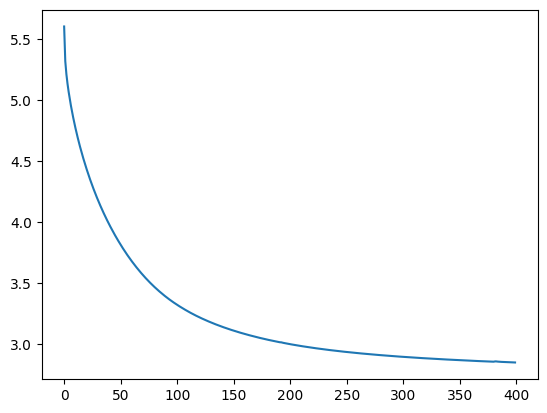

In [31]:
plt.plot(epoch_losses)

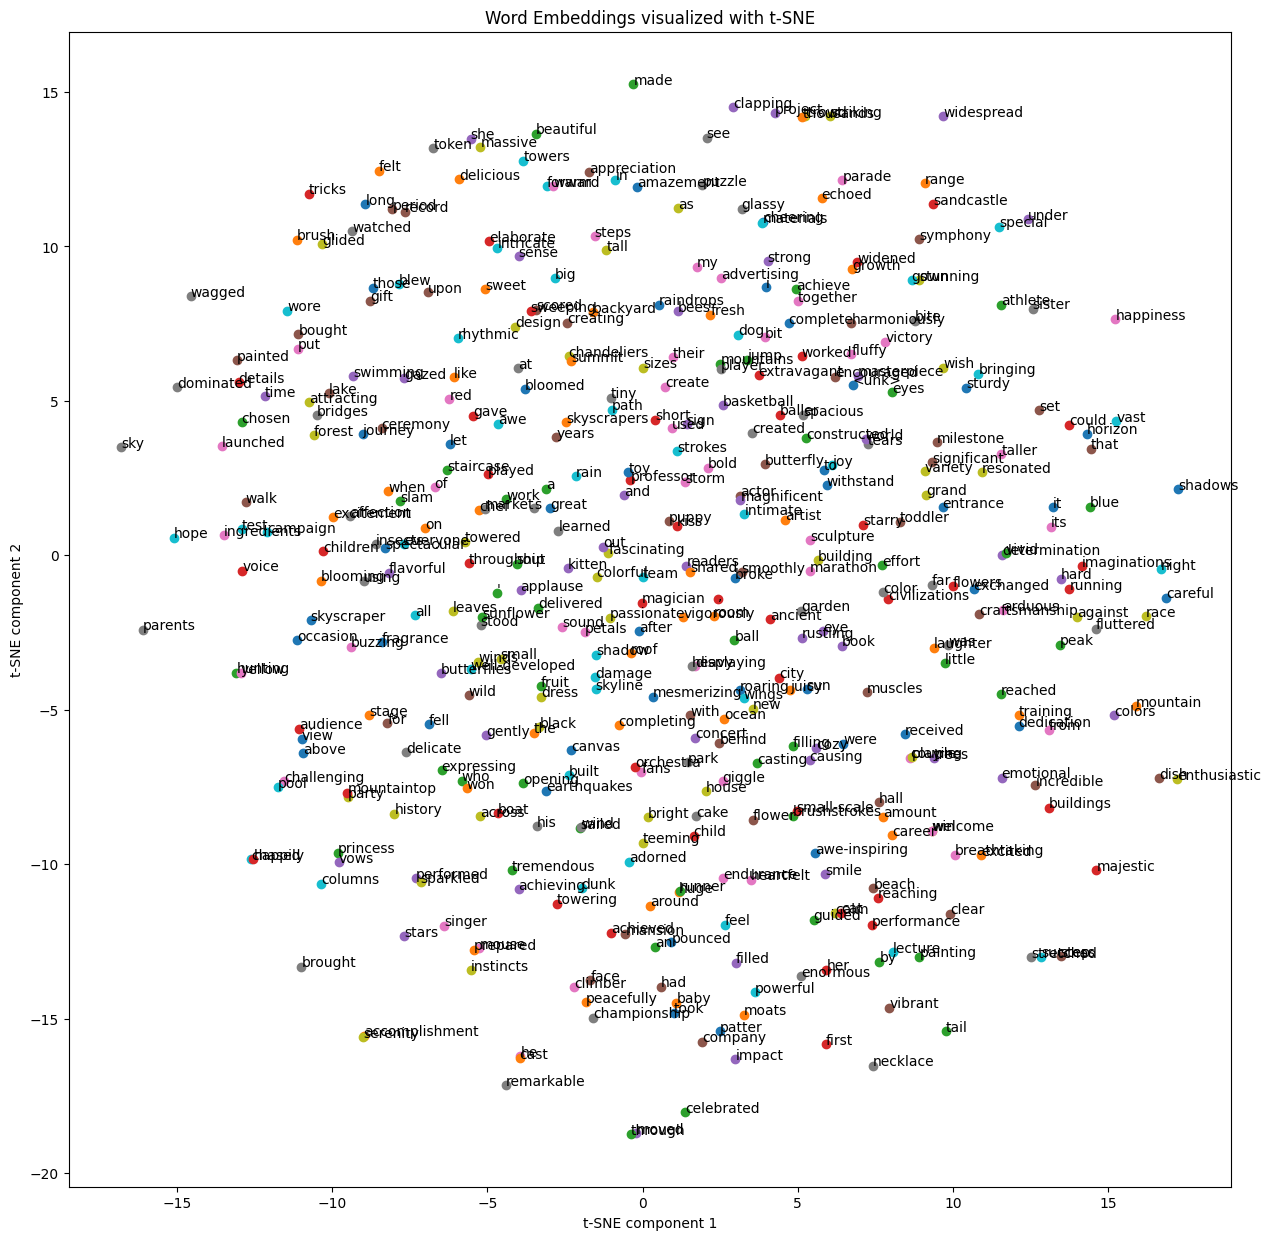

In [32]:
word_embeddings = model_sg.embeddings.weight.detach().cpu().numpy()
plot_embeddings(word_embeddings,vocab=vocab)

### CBOW vs Skip-Gram

- small dataset & need good representation of rarer words -> Skip-gram
- computational efficiency is more critical & rare words are less concern -> CBOW
- note: very small datasets neural word embeddings have limited benefits -> simpler methods or leveraging pretrained embeddings might be more effective

# Applying pretrained word embeddings

- Transfer learning: leverages knowledge gleaned from one task (typically learned over massive datasets), and applies it to another (often more specialized task) -> a strategic shortcut to enhanced performance in NLP.
- primary advantage: 1) bypasses computational resources to learn from scratch 2) injects a base layer of linguistic understanding into the model

In [33]:
# Pretrained GloVe model from Stanford
# creating an instance of the 6B version of Glove() model
glove_vectors_6B = GloVe(name ='6B') # specify model with following format: GloVe(name='840B', dim=300)
# glove_vectors_840B = GloVe()

In [34]:
# load the glove model pretrained weights into a PyTorch embedding layer
embeddings_Glove6B = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)

In [35]:
# Vocabulary index mapping
word_to_index = glove_vectors_6B.stoi
print(word_to_index['team'])
print(embeddings_Glove6B.weight[word_to_index['team']])

145
tensor([-2.7011e-02,  1.1299e+00,  4.4708e-02, -4.0380e-01, -4.7284e-02,
         9.2736e-02, -2.0715e-01,  2.6137e-01,  2.4730e-01, -8.8769e-01,
         3.1309e-01, -1.4940e-01,  4.9929e-03, -1.1520e-01, -1.7990e-01,
         6.4681e-01,  1.5044e-01, -3.4580e-01,  2.3370e-03, -7.5788e-01,
         1.6048e-01, -2.9066e-02,  1.7194e-01, -4.2799e-02,  3.4297e-02,
        -1.1400e-01, -2.1149e-01,  3.6118e-01, -3.3393e-01, -1.3581e-01,
         1.7858e-01, -2.3381e-01, -8.3367e-02,  1.0626e-01, -1.7301e+00,
         5.2052e-01,  3.7855e-01,  5.5852e-01, -1.0172e-01, -1.8644e-01,
        -1.2096e-01, -5.2009e-02,  1.9565e-01, -1.2685e-01, -3.7493e-01,
         9.7457e-02,  1.7014e-01,  7.7521e-02, -2.1946e-01,  1.4490e-01,
         1.2733e-01, -2.2223e-01, -3.1548e-01,  1.1137e-01, -4.0263e-01,
         8.3553e-01, -7.5475e-03,  3.6725e-01,  1.2324e-02, -1.0033e-01,
        -6.0014e-01,  4.2763e-01, -2.4048e-01, -2.8162e-01,  4.6409e-02,
        -3.7942e-01, -8.0836e-02, -3.2884e-01, 

In [36]:
# an array of example words
words = [
    "taller",
    "short",
    "black",
    "white",
    "dress",
    "pants",
    "big",
    "small",
    "red",
    "blue",
    "smile",
    "frown",
    "race",
    "stroll",
    "tiny",
    "huge",
    "soft",
    "rough",
    "team",
    "individual"
]


embedding_dict_Glove6B = {}
for word in words:
    # Get the index of the word from the vocabulary to access its embedding
    embedding_vector = embeddings_Glove6B.weight[word_to_index[word]]
    if embedding_vector is not None:
        # Words not found in the embedding index will be skipped.
        # add the embedding vector of word to the embedding_dict_Glove6B
        embedding_dict_Glove6B[word] = embedding_vector

In [37]:
# Call the function to find similar words
target_word = "small"
top_k = 2
similar_words = find_similar_words(target_word, embedding_dict_Glove6B, top_k)

# Print the similar words
print("{} most similar words to {}:".format(top_k,target_word) ,similar_words)

2 most similar words to small: ['tiny', 'big']


# Train a word2vec model from gensim

In [38]:
# Prepare corpus
sentences = [["I", "like", "to", "eat", "pizza"],
             ["Pizza", "is", "my", "favorite", "food"],
             ["I", "enjoy", "eating", "pasta"]]
sentences = [[word.lower() for word in sentence] for sentence in sentences]
sentences

[['i', 'like', 'to', 'eat', 'pizza'],
 ['pizza', 'is', 'my', 'favorite', 'food'],
 ['i', 'enjoy', 'eating', 'pasta']]

In [39]:
from gensim.models import Word2Vec

# Create an instance of Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=3, min_count=1, workers=4)

# Build vocab using the training data
w2v_model.build_vocab(sentences, progress_per=10000)

# Train the model on your training data
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(55, 420)

In [40]:
w2v_model

In [41]:
# Finding similar words
similar_words = w2v_model.wv.most_similar("pizza")
print("Similar words to 'pizza':", similar_words)

# Calculating word similarity
similarity = w2v_model.wv.similarity("pizza", "pasta")
print("Similarity between 'pizza' and 'pasta':", similarity)

Similar words to 'pizza': [('to', 0.17027318477630615), ('is', 0.13898280262947083), ('my', 0.035433270037174225), ('like', 0.00451968889683485), ('pasta', -0.005902299657464027), ('i', -0.027743974700570107), ('favorite', -0.028113720938563347), ('eat', -0.04430948570370674), ('food', -0.06873457878828049), ('enjoy', -0.1732126623392105)]
Similarity between 'pizza' and 'pasta': -0.00590231


In [42]:
# Extract word vectors and create word-to-index mapping
word_vectors = w2v_model.wv
# a dictionary to map words to their index in vocab
word_to_index = {word: index for index, word in enumerate(word_vectors.index_to_key)}

# Create an instance of nn.Embedding and load it with the trained vectors
embedding_dim = w2v_model.vector_size
embedding = torch.nn.Embedding(len(word_vectors.index_to_key), embedding_dim)
embedding.weight.data.copy_(torch.from_numpy(word_vectors.vectors))

# Example usage: get the embedding for a word
word = "pizza"
word_index = word_to_index[word]
word_embedding = embedding(torch.LongTensor([word_index]))
print(f"Word: {word}, Embedding: {word_embedding.detach().numpy()}")

Word: pizza, Embedding: [[-0.00714092  0.00124133 -0.00717793 -0.00224098  0.00372044  0.00583255
   0.00120101  0.00210401 -0.00411258  0.00722417 -0.00630454  0.00464709
  -0.00821901  0.00203745 -0.00497656 -0.00424712 -0.00310588  0.00565446
   0.00579693 -0.00497813  0.00077411 -0.00849433  0.00781365  0.00925739
  -0.00274148  0.00080058  0.00074548  0.00547892 -0.00860763  0.00058273
   0.00687327  0.00223279  0.0011247  -0.00932057  0.00847972 -0.00626165
  -0.00299271  0.00349315 -0.0007744   0.00141046  0.00178483 -0.00682816
  -0.00972361  0.00903822  0.00620081 -0.00691076  0.00340142  0.0002056
   0.00475387 -0.00712     0.00402757  0.0043473   0.00995535 -0.0044746
  -0.00139121 -0.00732087 -0.00969911 -0.00908164 -0.00102246 -0.00650654
   0.0048497  -0.00616394  0.00252445  0.00073935 -0.00339426 -0.0009791
   0.0099768   0.00914695 -0.00446548  0.00908081 -0.00564203  0.00593325
  -0.00309734  0.00343278  0.00301738  0.00689681 -0.00237353  0.00877608
   0.00758863 -0.

# Text classification using pretrained word embeddings

In [43]:
from torchtext.vocab import GloVe,vocab
# Build vocab from glove_vectors
# vocab(ordered_dict: Dict, min_freq: int = 1, specials: Optional[List[str]] = None)
vocab = vocab(glove_vectors_6B.stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

In [44]:
vocab(["<unk>","Hello","hello"])

[0, 0, 13077]

In [45]:
# Define tokenizer

tokenizer = get_tokenizer("basic_english")
# Define functions to process text and labels

In [49]:
from torchtext.datasets import AG_NEWS
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data.dataset import random_split

# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.85)

# Randomly split the training dat aset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [50]:
# define class labels
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
'''ag_news_label[y]'''
num_class = len(set([label for (label, text) in train_iter ]))

In [51]:
# Collate data in batches
def text_pipeline(x):
    x=x.lower()# you need this as your vocab is in lower case
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x) - 1

# create label, text and offset for each batch of data
# text is the concatenated text for all text data in the batch
# you need to have the offsets(the end of text index) for later when you separate texts and predict their label
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


In [52]:
# Create data loaders for train, validation and test splits
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
label, text, offsets=next(iter(train_dataloader ))
print(label, text, offsets)
label.shape, text.shape, offsets.shape

tensor([1, 0, 1, 0, 3, 1, 2, 2, 1, 2, 2, 2, 3, 0, 3, 2, 1, 1, 1, 0, 1, 0, 3, 2,
        1, 2, 0, 0, 2, 1, 1, 3, 2, 2, 2, 2, 1, 0, 0, 3, 1, 3, 3, 2, 2, 1, 0, 2,
        3, 2, 2, 2, 3, 1, 0, 0, 0, 3, 3, 2, 0, 0, 2, 3]) tensor([4172,   38,  624,  ...,  339,   18,    4]) tensor([   0,   35,   78,  118,  151,  196,  231,  285,  325,  381,  427,  486,
         523,  547,  590,  628,  672,  698,  724,  770,  800,  838,  896,  941,
        1013, 1054, 1092, 1132, 1182, 1230, 1270, 1297, 1336, 1372, 1416, 1453,
        1500, 1536, 1581, 1635, 1662, 1699, 1753, 1788, 1838, 1886, 1919, 1959,
        2009, 2036, 2085, 2131, 2176, 2202, 2236, 2283, 2338, 2384, 2402, 2436,
        2482, 2531, 2582, 2631, 2671])


(torch.Size([64]), torch.Size([2671]), torch.Size([65]))

In [53]:
# Create the classifier model
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text,offsets):
        embedded = self.embedding(text)
        # you get the average of word embeddings in the text
        means = []
        for i in range(1,len(offsets)):
            #this is like eme
          text_tmp = embedded[offsets[i-1]:offsets[i]]
          means.append(text_tmp.mean(0))

        return self.fc(torch.stack(means))

In [54]:
# Define an evaluate function to calculate the accuracy of model
def evaluate(dataloader, model):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text,offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [55]:
# Define hyperparameters
vocab_size=len(vocab)
embedding_dim = 300
# Initialize the model
model = TextClassificationModel(vocab_size, embedding_dim, num_class).to(device)

In [56]:
evaluate(test_dataloader, model)

0.2623684210526316

In [59]:
# Not good! Let's train the model
def train_TextClassification(model,dataloader,criterion,optimizer,epochs=10):

    cum_loss_list=[]
    acc_epoch=[]
    acc_old=0

    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        cum_loss=0
        for idx, (label, text, offsets) in enumerate(train_dataloader):
            means = []
            optimizer.zero_grad()


            predicted_label = model(text, offsets)

            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss+=loss.item()

        cum_loss_list.append(cum_loss/len(train_dataloader))
        accu_val = evaluate(valid_dataloader, model)
        acc_epoch.append(accu_val)

        if accu_val > acc_old:
          acc_old= accu_val
          torch.save(model.state_dict(), 'my_model.pth')

    return model,cum_loss_list,acc_epoch

In [60]:
# Define hyperparameters
LR=0.1
EPOCHS = 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model,cum_loss_list,acc_epoch  = train_TextClassification(model,train_dataloader,criterion,optimizer,EPOCHS)

100%|██████████| 10/10 [03:33<00:00, 21.39s/it]


In [61]:
# plot the loss and accuracy for the trained model
import matplotlib.pyplot as plt
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

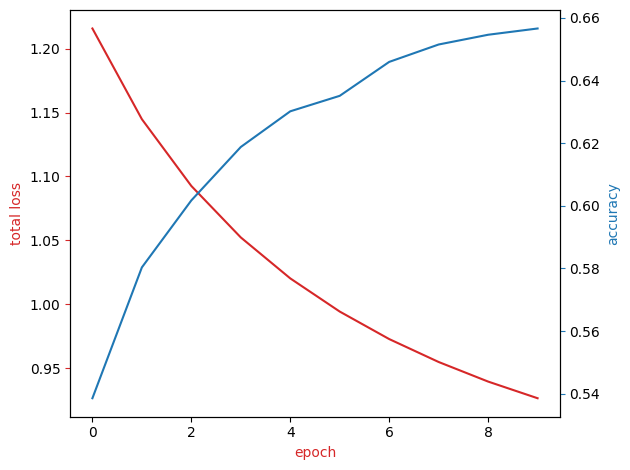

In [62]:
plot(cum_loss_list,acc_epoch)

In [63]:
evaluate(test_dataloader, model)

0.6538157894736842